# Linear Regression using PyTorch

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

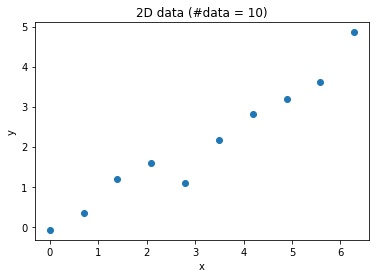

In [6]:
N = 10 # number of data points
m = .7
c = 0
x = np.linspace(0,2*np.pi,N)
y = m*x + c + np.random.normal(0,.3,x.shape)
plt.figure()
plt.plot(x,y,'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D data (#data = %d)' % N)
plt.show()

In [7]:
import torch

## Dataset

In [8]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = {
            'feature': torch.tensor([1,self.x[idx]]), 
            'label': torch.tensor([self.y[idx]])}
        return sample

In [9]:
dataset = MyDataset(x, y)
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['feature'], sample['label'])

0 tensor([1., 0.]) tensor([-0.0810])
1 tensor([1.0000, 0.6981]) tensor([0.3358])
2 tensor([1.0000, 1.3963]) tensor([1.1995])
3 tensor([1.0000, 2.0944]) tensor([1.6029])
4 tensor([1.0000, 2.7925]) tensor([1.0966])
5 tensor([1.0000, 3.4907]) tensor([2.1744])
6 tensor([1.0000, 4.1888]) tensor([2.8280])
7 tensor([1.0000, 4.8869]) tensor([3.2023])
8 tensor([1.0000, 5.5851]) tensor([3.6039])
9 tensor([1.0000, 6.2832]) tensor([4.8596])


## Dataloader

In [10]:
from torch.utils.data import DataLoader

dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

In [11]:
import pprint as pp
for i_batch, samples in enumerate(dataloader):
    print('\nbatch# = %s' % i_batch)
    print('samples: ')
    pp.pprint(samples)


batch# = 0
samples: 
{'feature': tensor([[1.0000, 6.2832],
        [1.0000, 3.4907],
        [1.0000, 2.7925],
        [1.0000, 1.3963]]),
 'label': tensor([[4.8596],
        [2.1744],
        [1.0966],
        [1.1995]])}

batch# = 1
samples: 
{'feature': tensor([[1.0000, 5.5851],
        [1.0000, 4.8869],
        [1.0000, 4.1888],
        [1.0000, 2.0944]]),
 'label': tensor([[3.6039],
        [3.2023],
        [2.8280],
        [1.6029]])}

batch# = 2
samples: 
{'feature': tensor([[1.0000, 0.0000],
        [1.0000, 0.6981]]),
 'label': tensor([[-0.0810],
        [ 0.3358]])}


## Model

In [12]:
import torch.nn as nn
from torch.nn.parameter import Parameter
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyModel, self).__init__()
        
        self.weight = Parameter(torch.Tensor(output_dim, input_dim))
        self.bias = Parameter(torch.Tensor(output_dim, 1))
        
        stdv = 1.
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)
        
    def forward(self, x):
        weight_and_bias = torch.cat((self.weight, self.bias), 1)
        #print(weight_and_bias)
        #print(weight_and_bias.t().shape)
        #print(x.shape)
        #print(self.weight.size())
        
        out = x.matmul(weight_and_bias.t())
        return out

### Setting a model for our problem

In [14]:
input_dim = 1
output_dim = 1

model = MyModel(input_dim, output_dim)

#model(torch.rand([5,2]))

## Cost function

Often called loss or error

In [15]:
#cost = nn.MSELoss()

In [22]:
import torch.nn as nn
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        
    def forward(self, predictions, targets):
        print(predictions)
        print(targets)
        
        diff = torch.sub(predictions, targets)
        diff2 = torch.pow(diff, 2)
        err = torch.sum(diff2)
        return err

In [23]:
cost = MyLoss()

## Minimizing the cost function

In other words training (or learning from data)

In [24]:
num_epochs = 100  # How many times the entire training data is seen?
l_rate = 0.01
optimiser = torch.optim.SGD(model.parameters(), lr = l_rate) 

dataset = MyDataset(x, y)
batch_size = 4
shuffle = True
num_workers = 4
training_sample_generator = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

for epoch in range(num_epochs):
    if epoch % 10 == 0:
        print('Epoch = %s' % epoch)
    for batch_i, samples in enumerate(training_sample_generator):
        predictions = model(samples['feature'])
        error = cost(predictions, samples['label'])
        if epoch % 10 == 0:
            print('\tBatch = %s, Error = %s' % (batch_i, error.item()))
        
        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimiser.zero_grad()
        
        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        error.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimiser.step()

Epoch = 0
tensor([[-1.1168],
        [-1.5429],
        [-0.2646],
        [-1.4008]], grad_fn=<MmBackward>)
tensor([[ 2.8280],
        [ 4.8596],
        [-0.0810],
        [ 3.6039]])
	Batch = 0, Error = 81.63423156738281
tensor([[3.1681],
        [5.2494],
        [4.2087],
        [7.3307]], grad_fn=<MmBackward>)
tensor([[1.6029],
        [2.1744],
        [1.0966],
        [3.2023]])
	Batch = 1, Error = 38.63407897949219
tensor([[0.2505],
        [0.6924]], grad_fn=<MmBackward>)
tensor([[0.3358],
        [1.1995]])
	Batch = 2, Error = 0.2644203007221222
tensor([[0.7257],
        [1.1784],
        [0.2730],
        [3.4418]], grad_fn=<MmBackward>)
tensor([[1.1995],
        [1.6029],
        [0.3358],
        [3.6039]])
tensor([[2.2807],
        [3.2559],
        [4.2311],
        [2.7683]], grad_fn=<MmBackward>)
tensor([[2.1744],
        [3.2023],
        [4.8596],
        [2.8280]])
tensor([[ 2.0029],
        [-0.1466]], grad_fn=<MmBackward>)
tensor([[ 1.0966],
        [-0.0810]])

tensor([[-0.1707],
        [ 2.5753],
        [ 4.7721],
        [ 3.1245]], grad_fn=<MmBackward>)
tensor([[-0.0810],
        [ 2.1744],
        [ 4.8596],
        [ 2.8280]])
tensor([[1.8989],
        [0.3389],
        [3.9789],
        [1.3789]], grad_fn=<MmBackward>)
tensor([[1.0966],
        [0.3358],
        [3.6039],
        [1.6029]])
tensor([[0.7318],
        [3.0617]], grad_fn=<MmBackward>)
tensor([[1.1995],
        [3.2023]])
Epoch = 20
tensor([[ 0.2967],
        [-0.1880],
        [ 2.7202],
        [ 3.2048]], grad_fn=<MmBackward>)
tensor([[ 0.3358],
        [-0.0810],
        [ 2.8280],
        [ 3.2023]])
	Batch = 0, Error = 0.024611301720142365
tensor([[3.7467],
        [4.2379],
        [0.7994],
        [1.2906]], grad_fn=<MmBackward>)
tensor([[3.6039],
        [4.8596],
        [1.1995],
        [1.6029]])
	Batch = 1, Error = 0.6645837426185608
tensor([[2.0470],
        [2.5986]], grad_fn=<MmBackward>)
tensor([[1.0966],
        [2.1744]])
	Batch = 2, Error = 1.0831892

tensor([[2.3674],
        [2.7929],
        [1.9420],
        [0.6655]], grad_fn=<MmBackward>)
tensor([[2.8280],
        [3.2023],
        [2.1744],
        [1.1995]])
tensor([[0.3494],
        [4.3661],
        [1.8556],
        [1.3536]], grad_fn=<MmBackward>)
tensor([[0.3358],
        [4.8596],
        [1.0966],
        [1.6029]])
tensor([[-0.1533],
        [ 4.0303]], grad_fn=<MmBackward>)
tensor([[-0.0810],
        [ 3.6039]])
tensor([[-0.1604],
        [ 4.2469],
        [ 3.7572],
        [ 2.2881]], grad_fn=<MmBackward>)
tensor([[-0.0810],
        [ 4.8596],
        [ 3.6039],
        [ 2.1744]])
tensor([[1.9520],
        [0.3741],
        [3.5298],
        [0.9000]], grad_fn=<MmBackward>)
tensor([[1.0966],
        [0.3358],
        [3.2023],
        [1.1995]])
tensor([[2.6840],
        [1.2569]], grad_fn=<MmBackward>)
tensor([[2.8280],
        [1.6029]])
Epoch = 40
tensor([[ 2.8051],
        [-0.1605],
        [ 1.3223],
        [ 0.3338]], grad_fn=<MmBackward>)
tensor([[ 2.82

tensor([[2.2814],
        [0.3123],
        [1.7891],
        [2.7737]], grad_fn=<MmBackward>)
tensor([[2.1744],
        [0.3358],
        [1.0966],
        [2.8280]])
tensor([[ 1.1960],
        [-0.1944],
        [ 3.0498],
        [ 3.9768]], grad_fn=<MmBackward>)
tensor([[ 1.6029],
        [-0.0810],
        [ 3.2023],
        [ 4.8596]])
tensor([[4.3425],
        [0.9631]], grad_fn=<MmBackward>)
tensor([[3.6039],
        [1.1995]])
tensor([[3.3983],
        [0.3369],
        [4.4187],
        [1.3574]], grad_fn=<MmBackward>)
tensor([[3.2023],
        [0.3358],
        [4.8596],
        [1.6029]])
tensor([[0.9219],
        [4.1781],
        [2.5500],
        [2.0073]], grad_fn=<MmBackward>)
tensor([[1.1995],
        [3.6039],
        [2.1744],
        [1.0966]])
tensor([[ 2.5020],
        [-0.1952]], grad_fn=<MmBackward>)
tensor([[ 2.8280],
        [-0.0810]])
tensor([[4.0310],
        [3.5624],
        [2.1566],
        [2.6252]], grad_fn=<MmBackward>)
tensor([[4.8596],
        [3.

tensor([[0.9764],
        [2.6730]], grad_fn=<MmBackward>)
tensor([[1.1995],
        [2.1744]])
tensor([[1.4766],
        [3.1133],
        [2.5677],
        [0.3855]], grad_fn=<MmBackward>)
tensor([[1.6029],
        [2.8280],
        [2.1744],
        [0.3358]])
tensor([[-0.1722],
        [ 4.4442],
        [ 1.8795],
        [ 0.8537]], grad_fn=<MmBackward>)
tensor([[-0.0810],
        [ 4.8596],
        [ 1.0966],
        [ 1.1995]])
tensor([[4.0340],
        [3.5084]], grad_fn=<MmBackward>)
tensor([[3.6039],
        [3.2023]])
tensor([[ 0.7568],
        [-0.1855],
        [ 2.6415],
        [ 2.1703]], grad_fn=<MmBackward>)
tensor([[ 1.1995],
        [-0.0810],
        [ 2.8280],
        [ 2.1744]])
tensor([[3.2656],
        [1.3020],
        [0.3202],
        [1.7929]], grad_fn=<MmBackward>)
tensor([[3.2023],
        [1.6029],
        [0.3358],
        [1.0966]])
tensor([[3.5675],
        [4.0359]], grad_fn=<MmBackward>)
tensor([[3.6039],
        [4.8596]])
tensor([[ 4.7290],
     

tensor([[ 2.7511],
        [ 1.2922],
        [ 2.2648],
        [-0.1666]], grad_fn=<MmBackward>)
tensor([[ 2.8280],
        [ 1.6029],
        [ 2.1744],
        [-0.0810]])
tensor([[1.8229],
        [0.3365],
        [3.8047],
        [4.3002]], grad_fn=<MmBackward>)
tensor([[1.0966],
        [0.3358],
        [3.6039],
        [4.8596]])
tensor([[0.8348],
        [3.3375]], grad_fn=<MmBackward>)
tensor([[1.1995],
        [3.2023]])
tensor([[ 0.8351],
        [-0.1617],
        [ 0.3367],
        [ 2.3304]], grad_fn=<MmBackward>)
tensor([[ 1.1995],
        [-0.0810],
        [ 0.3358],
        [ 2.1744]])
tensor([[3.8274],
        [3.3295],
        [4.3254],
        [1.8357]], grad_fn=<MmBackward>)
tensor([[3.6039],
        [3.2023],
        [4.8596],
        [1.0966]])
tensor([[2.7721],
        [1.3025]], grad_fn=<MmBackward>)
tensor([[2.8280],
        [1.6029]])
tensor([[2.3496],
        [1.3458],
        [3.8554],
        [3.3535]], grad_fn=<MmBackward>)
tensor([[2.1744],
       

## Lets see how well the model has learnt the data

In [25]:
#from torch.autograd.variable import Variable

x_for_plotting = np.linspace(0, 2*np.pi, 1000)
design_matrix = torch.tensor(np.vstack([np.ones(x_for_plotting.shape), x_for_plotting]).T, dtype=torch.float32)
#print('Design matrix:\n', design_matrix)
print('Design matrix shape:', design_matrix.shape)

y_for_plotting = model.forward(design_matrix)
print('y_for_plotting shape:', y_for_plotting.shape)

Design matrix shape: torch.Size([1000, 2])
y_for_plotting shape: torch.Size([1000, 1])


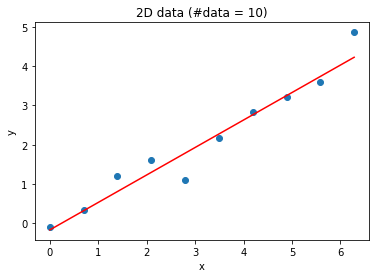

In [26]:
plt.figure()
plt.plot(x,y,'o')
plt.plot(x_for_plotting, y_for_plotting.data.numpy(), 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D data (#data = %d)' % N)
plt.show()